# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'vae'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h       snow_1h  \
count   342132.000000  342132.000000  342132.000000  3.421320e+05   
mean      3366.341044     279.580688       0.000043  9.822446e-07   
std       1325.479789       8.288843       0.008416  1.013814e-04   
min          0.000000     243.389999       0.000000  0.000000e+00   
25%       2306.906555     273.842377       0.000000  0.000000e+00   
50%       3564.369873     280.706314       0.000000  0.000000e+00   
75%       4469.899414     286.344513       0.000000  0.000000e+00   
max       8338.763672     299.354462       2.695585  1.833022e-02   

          clouds_all  
count  342132.000000  
mean       43.752227  
std        31.562162  
min         0.000000  
25%        12.254412  
50%        40.534121  
75%        77.385469  
max       123.448143  


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  

In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,342132.000000,342132.000000,342132.000000,3.421320e+05,342132.000000
mean,3366.341044,279.580688,0.000043,9.822446e-07,43.752227
std,1325.479789,8.288843,0.008416,1.013814e-04,31.562162
min,0.000000,243.389999,0.000000,0.000000e+00,0.000000
25%,2306.906555,273.842377,0.000000,0.000000e+00,12.254412
50%,3564.369873,280.706314,0.000000,0.000000e+00,40.534121
75%,4469.899414,286.344513,0.000000,0.000000e+00,77.385469
max,8338.763672,299.354462,2.695585,1.833022e-02,123.448143


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.3259031067788601
Training Loss: 0.25168567419052124
Training Loss: 0.171121084690094
Validation Loss: 0.1101935382806853
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0969249064475298
Training Loss: 0.0774563978612423
Training Loss: 0.07010636260733008
Validation Loss: 0.06528446153643426
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06788131415843963
Training Loss: 0.0659365044347942
Training Loss: 0.06459600431844592
Validation Loss: 0.060461483184206355
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.062395116165280345
Training Loss: 0.06006688296794891
Training Loss: 0.05825364736840129
Validation Loss: 0.054031507729479435
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05519489638507366
Training Loss: 0.052567760553210975
Training Loss: 0

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:23<30:31, 203.52s/it]

Epoch: 1
Training Loss: 0.1452367489412427
Training Loss: 0.10769495349377393
Training Loss: 0.08324906505644321
Validation Loss: 0.06894260536084014
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06994405332952738
Training Loss: 0.06571161165833474
Training Loss: 0.06325409803539514
Validation Loss: 0.05949159473013342
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05978085696697235
Training Loss: 0.05667549941688776
Training Loss: 0.05414996571838856
Validation Loss: 0.050080903879042425
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04947153620421887
Training Loss: 0.045894241761416196
Training Loss: 0.042714242972433564
Validation Loss: 0.03827153160916955
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.037436974672600626
Training Loss: 0.0340555452182889
Training Lo

 20%|██        | 2/10 [06:49<27:20, 205.12s/it]

Training Loss: 0.005474056245293468
Validation Loss: 0.002729581904419687
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0749977726303041
Training Loss: 0.06836423421278597
Training Loss: 0.06538385407999157
Validation Loss: 0.06055281453588036
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.061299430895596745
Training Loss: 0.05759363109245896
Training Loss: 0.05433935353532433
Validation Loss: 0.04898034069645271
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04947954876348376
Training Loss: 0.0458152221981436
Training Loss: 0.042461718013510105
Validation Loss: 0.03707284741940793
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03742319913581014
Training Loss: 0.03416666769422591
Training Loss: 0.03103984328918159
Validation Loss: 0.026321033235597476
Validation Accura

 30%|███       | 3/10 [10:15<23:57, 205.33s/it]

Training Loss: 0.005635211843764409
Validation Loss: 0.0026058569626380384
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0641798423230648
Training Loss: 0.061380841154605154
Training Loss: 0.05972524210810661
Validation Loss: 0.0550756985216998
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05639070741832256
Training Loss: 0.05323360705748201
Training Loss: 0.05053602023050189
Validation Loss: 0.04464721445287211
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.045506402291357516
Training Loss: 0.041709526525810364
Training Loss: 0.03829362046904862
Validation Loss: 0.03234141510440392
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03310199928469956
Training Loss: 0.030026921443641184
Training Loss: 0.027217590427026154
Validation Loss: 0.022649026203775003
Validation Ac

 40%|████      | 4/10 [13:42<20:37, 206.20s/it]

Training Loss: 0.005490640917560086
Validation Loss: 0.0027207239345239287
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07194626374170184
Training Loss: 0.06612320214509965
Training Loss: 0.06287226429209113
Validation Loss: 0.05649216975388902
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05769610581919551
Training Loss: 0.05307806147262454
Training Loss: 0.0491281726770103
Validation Loss: 0.042412982793169074
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04286660888232291
Training Loss: 0.03842102366499603
Training Loss: 0.03461409032344818
Validation Loss: 0.029291344785623338
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.029404755998402834
Training Loss: 0.026475074463523925
Training Loss: 0.023942280891351402
Validation Loss: 0.02041550770694955
Validation Ac

 50%|█████     | 5/10 [17:09<17:12, 206.40s/it]

Training Loss: 0.004829352450906299
Validation Loss: 0.002169290219376052
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.48908831775188444
Training Loss: 0.3859197896718979
Training Loss: 0.2776004868000746
Validation Loss: 0.1609658394636733
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.15581713747233153
Training Loss: 0.11049964103847743
Training Loss: 0.08660868790000677
Validation Loss: 0.07335307595602582
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07663092596456408
Training Loss: 0.07371484501287341
Training Loss: 0.07241421038284898
Validation Loss: 0.06923654160640214
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0696838646940887
Training Loss: 0.0669715411402285
Training Loss: 0.06519439065828919
Validation Loss: 0.061398568699199164
Validation Accuracy: 0

 60%|██████    | 6/10 [20:36<13:46, 206.51s/it]

Training Loss: 0.006366409370675683
Validation Loss: 0.0035212235028196253
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.464681363850832
Training Loss: 0.3698252352327108
Training Loss: 0.26338690221309663
Validation Loss: 0.17479354645429032
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14418041929602624
Training Loss: 0.09937891971319913
Training Loss: 0.07542292606085539
Validation Loss: 0.06347374927796674
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06585454549640417
Training Loss: 0.06242387695237994
Training Loss: 0.059770598020404575
Validation Loss: 0.054043618062239014
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.056028020977973936
Training Loss: 0.05277278323657811
Training Loss: 0.04977297627367079
Validation Loss: 0.044083266236474
Validation Accuracy

 70%|███████   | 7/10 [24:02<10:19, 206.53s/it]

Validation Loss: 0.003267544343952466
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4295069570839405
Training Loss: 0.34221637189388276
Training Loss: 0.22986517302691936
Validation Loss: 0.1298822175418393
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10611995996907353
Training Loss: 0.07925332160666584
Training Loss: 0.0729472703114152
Validation Loss: 0.06677737371640259
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06734642755240201
Training Loss: 0.06275890238583087
Training Loss: 0.05996022185310721
Validation Loss: 0.05610439164584942
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.055081079620867966
Training Loss: 0.051524890046566726
Training Loss: 0.04911094375886023
Validation Loss: 0.045890820934698824
Validation Accuracy: 0.0
*****************************

 80%|████████  | 8/10 [27:29<06:52, 206.49s/it]

Training Loss: 0.006434160429053009
Validation Loss: 0.0035167348589434217
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11610212560743094
Training Loss: 0.09257816458120942
Training Loss: 0.07904229018837214
Validation Loss: 0.07188228467542133
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07307987429201603
Training Loss: 0.07040008138865232
Training Loss: 0.06866196839138866
Validation Loss: 0.0635710624831446
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06601484514772891
Training Loss: 0.06334005273878575
Training Loss: 0.061134413592517374
Validation Loss: 0.05520359380693918
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05743612201884389
Training Loss: 0.054224586486816405
Training Loss: 0.05138685036450624
Validation Loss: 0.045399637725413514
Validation Accu

 90%|█████████ | 9/10 [30:56<03:26, 206.68s/it]

Training Loss: 0.006360831139609217
Validation Loss: 0.0034736177407916676
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3929079297930002
Training Loss: 0.2558523894101381
Training Loss: 0.13457364335656166
Validation Loss: 0.07319431622209174
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06968156794086099
Training Loss: 0.06204661821946502
Training Loss: 0.059445162583142516
Validation Loss: 0.05488147473569666
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.057332550529390576
Training Loss: 0.05459520982578397
Training Loss: 0.05222799053415656
Validation Loss: 0.047606877103615344
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04928648641332984
Training Loss: 0.046295582791790364
Training Loss: 0.04355127459391952
Validation Loss: 0.039054957605647235
Validation Acc

100%|██████████| 10/10 [34:23<00:00, 206.72s/it]

Training Loss: 0.0067132516147103164
Validation Loss: 0.003689604748584581
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [34:23<00:00, 206.32s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.1217415614053607
Training Loss: 0.09894338877871632
Training Loss: 0.08276687614619732
Validation Loss: 0.07597649681350488
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07249544048681855
Training Loss: 0.06992725057527423
Training Loss: 0.06695682816207409
Validation Loss: 0.06788615840539504
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06685731565579772
Training Loss: 0.06533857813104987
Training Loss: 0.06252222610637545
Validation Loss: 0.06260449343015638
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06158211035653949
Training Loss: 0.05916761824861169
Training Loss: 0.05587158551439643
Validation Loss: 0.05447961852540461
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05334900532849133
Training Loss: 0.049799334974959496
Training Loss

 10%|█         | 1/10 [03:26<30:54, 206.08s/it]

Validation Loss: 0.00415164714331184
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4670819643139839
Training Loss: 0.3494882993400097
Training Loss: 0.23481794610619544
Validation Loss: 0.14991917465342564
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11945316851139069
Training Loss: 0.08983312832191587
Training Loss: 0.0769007927365601
Validation Loss: 0.07485575191258045
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07413737777620553
Training Loss: 0.07199589233845473
Training Loss: 0.06907604344189167
Validation Loss: 0.06940856379237068
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06929604114964605
Training Loss: 0.0673334750905633
Training Loss: 0.06457153484225273
Validation Loss: 0.06473423735228147
Validation Accuracy: 0.0
**********************************

 20%|██        | 2/10 [06:54<27:40, 207.50s/it]

Validation Loss: 0.00354054773074648
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3025254301726818
Training Loss: 0.2357554953172803
Training Loss: 0.1835014246404171
Validation Loss: 0.14562588473886587
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12279540453106165
Training Loss: 0.09648886831477284
Training Loss: 0.07889605768024921
Validation Loss: 0.07248396284124825
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06914087353274226
Training Loss: 0.06622508171945811
Training Loss: 0.06327852180227637
Validation Loss: 0.06381574365195264
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06325484139844775
Training Loss: 0.06157614393159747
Training Loss: 0.058951845690608025
Validation Loss: 0.05907207072367159
Validation Accuracy: 0.0
********************************

 30%|███       | 3/10 [10:23<24:16, 208.02s/it]

Validation Loss: 0.0036410918940653963
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5298350359499454
Training Loss: 0.3925378119945526
Training Loss: 0.2706178068369627
Validation Loss: 0.1546187548992339
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11958148809149861
Training Loss: 0.07347387928515672
Training Loss: 0.057147951889783145
Validation Loss: 0.05423830351216739
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05253387599252164
Training Loss: 0.05056350244209171
Training Loss: 0.047888613920658823
Validation Loss: 0.04690708618694812
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04509569814428687
Training Loss: 0.042438326459378006
Training Loss: 0.039625522131100294
Validation Loss: 0.03764932766933454
Validation Accuracy: 0.0
****************************

 40%|████      | 4/10 [13:51<20:49, 208.28s/it]

Epoch: 1
Training Loss: 0.06609551325440406
Training Loss: 0.06253208771348
Training Loss: 0.058117297301068904
Validation Loss: 0.05551622697058019
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.053451189426705244
Training Loss: 0.04915449277497828
Training Loss: 0.045095932967960835
Validation Loss: 0.04143229806063215
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03980841382406652
Training Loss: 0.03547893834300339
Training Loss: 0.03277474172879011
Validation Loss: 0.029061339785125147
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.028040181761607528
Training Loss: 0.024656382966786624
Training Loss: 0.023778589135035874
Validation Loss: 0.021422506132152644
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.021426566387526692
Training Loss: 0.01960746193304658
Trainin

 50%|█████     | 5/10 [17:20<17:22, 208.55s/it]

Validation Loss: 0.003218010745503092
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10398673318326473
Training Loss: 0.08670704225078225
Training Loss: 0.07478682078421116
Validation Loss: 0.07127325169825821
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06906947998329997
Training Loss: 0.066777490247041
Training Loss: 0.06326910194009543
Validation Loss: 0.06261163271879883
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061330713853240015
Training Loss: 0.05841007325798273
Training Loss: 0.05450132388621569
Validation Loss: 0.05234965922708592
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.051026010029017924
Training Loss: 0.046999671254307034
Training Loss: 0.04268824194557965
Validation Loss: 0.039009606769161945
Validation Accuracy: 0.0
***************************

 60%|██████    | 6/10 [20:50<13:54, 208.73s/it]

Validation Loss: 0.003162925898782867
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3466683398932219
Training Loss: 0.2659880153089762
Training Loss: 0.1868939424306154
Validation Loss: 0.11834013374166542
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09678000126034021
Training Loss: 0.07695183150470257
Training Loss: 0.07046710580587387
Validation Loss: 0.07092618462995867
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06960219847038389
Training Loss: 0.06817807791754603
Training Loss: 0.06539869792759419
Validation Loss: 0.065724179253317
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0644601240940392
Training Loss: 0.0627339649759233
Training Loss: 0.06002311579883099
Validation Loss: 0.059769629762413796
Validation Accuracy: 0.0
***********************************

 70%|███████   | 7/10 [24:18<10:26, 208.79s/it]

Validation Loss: 0.0030548166937529623
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5299800857901573
Training Loss: 0.39116242825984954
Training Loss: 0.2385704254731536
Validation Loss: 0.12476916992095079
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09516742769628764
Training Loss: 0.07209914634004236
Training Loss: 0.06502307885326446
Validation Loss: 0.06509150518627649
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06316760253161192
Training Loss: 0.06065163115039468
Training Loss: 0.05808560815639794
Validation Loss: 0.05814600403138091
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.056241516154259444
Training Loss: 0.05283806994557381
Training Loss: 0.04873647881671786
Validation Loss: 0.04422964859921276
Validation Accuracy: 0.0
*****************************

 80%|████████  | 8/10 [27:47<06:57, 208.82s/it]

Validation Loss: 0.0033624691468810016
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5167535808682442
Training Loss: 0.41209077954292295
Training Loss: 0.28750773809850216
Validation Loss: 0.15658972416533512
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11544180963188409
Training Loss: 0.07233507445082069
Training Loss: 0.06016848339699209
Validation Loss: 0.05856203076461058
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05655544969253242
Training Loss: 0.05369611551053822
Training Loss: 0.050957675157114864
Validation Loss: 0.05063081980588731
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04836117868311703
Training Loss: 0.04560531501658261
Training Loss: 0.043381575122475625
Validation Loss: 0.04312933354607124
Validation Accuracy: 0.0
***************************

 90%|█████████ | 9/10 [31:16<03:28, 208.78s/it]

Validation Loss: 0.004276695497742111
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7299213299155235
Training Loss: 0.6033445511758327
Training Loss: 0.4682847373187542
Validation Loss: 0.3162203493915247
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.23220652248710394
Training Loss: 0.11984925519675016
Training Loss: 0.07633883316069841
Validation Loss: 0.06765134684908926
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06495852280408144
Training Loss: 0.06290891658514738
Training Loss: 0.06036479311063886
Validation Loss: 0.060681234291765127
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05879633791744709
Training Loss: 0.056281001940369606
Training Loss: 0.05321235922165215
Validation Loss: 0.052132464819744734
Validation Accuracy: 0.0
******************************

100%|██████████| 10/10 [34:46<00:00, 208.61s/it]


Validation Loss: 0.0026323469372052867
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.19727846905589103
Training Loss: 0.12983515910804272
Training Loss: 0.08145264213904739
Validation Loss: 0.044245052364701665
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03392386263702065
Training Loss: 0.021653204690665007
Training Loss: 0.01927523633465171
Validation Loss: 0.01850131912646014
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.018208876084536314
Training Loss: 0.017211765833199024
Training Loss: 0.01653932406567037
Validation Loss: 0.015806111460291473
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.015467532430775463
Training Loss: 0.014428369109518826
Training Loss: 0.013631656097713859
Validation Loss: 0.012731852730496802
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.012341932056006043
Training Loss: 0.01122480537276715
Tra

 10%|█         | 1/10 [03:28<31:20, 208.99s/it]

Validation Loss: 4.254280766826669e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.36939772829413414
Training Loss: 0.2812684490531683
Training Loss: 0.1865137453004718
Validation Loss: 0.07960259115229772
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.048073415253311394
Training Loss: 0.019052799842320382
Training Loss: 0.015851455670781434
Validation Loss: 0.015459203182110906
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.01539354084758088
Training Loss: 0.014747279593721033
Training Loss: 0.014566606990993023
Validation Loss: 0.014252597018660114
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.014166565551422537
Training Loss: 0.013483034037053586
Training Loss: 0.013216806929558516
Validation Loss: 0.012840500512477739
Validation Accuracy: 0.0
*******************

 20%|██        | 2/10 [07:02<28:10, 211.36s/it]

Validation Loss: 5.192671275769839e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10380704769864678
Training Loss: 0.054250402692705396
Training Loss: 0.029609370487742127
Validation Loss: 0.019424651681794136
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.01800381238106638
Training Loss: 0.01634951074142009
Training Loss: 0.01594925741199404
Validation Loss: 0.01534790364640385
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.015020651540253312
Training Loss: 0.014078986211679877
Training Loss: 0.01348700375529006
Validation Loss: 0.012666038880072658
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.01229753588559106
Training Loss: 0.011238706815056503
Training Loss: 0.010519876054022461
Validation Loss: 0.009635982832054519
Validation Accuracy: 0.0
*******************

 30%|███       | 3/10 [10:37<24:53, 213.41s/it]

Validation Loss: 5.1483803664222907e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.29244460105896
Training Loss: 0.19084271531552077
Training Loss: 0.12144162930548191
Validation Loss: 0.06974311141744673
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.052675985265523195
Training Loss: 0.027713922541588543
Training Loss: 0.018014326789416373
Validation Loss: 0.014656857147750408
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.014071560078300537
Training Loss: 0.013579555382020771
Training Loss: 0.013420014278963208
Validation Loss: 0.012924179593465349
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.012669858788140118
Training Loss: 0.012324694979470223
Training Loss: 0.012070765499956906
Validation Loss: 0.011516062901797575
Validation Accuracy: 0.0
******************

 40%|████      | 4/10 [14:08<21:14, 212.35s/it]

Validation Loss: 3.2571880046054514e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06691253053024411
Training Loss: 0.03904188645072281
Training Loss: 0.024690683796070517
Validation Loss: 0.01822538753482383
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.017063847668468954
Training Loss: 0.01574794081505388
Training Loss: 0.01510227938881144
Validation Loss: 0.014145343613878475
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.013671661471016705
Training Loss: 0.012543501614127308
Training Loss: 0.01167070128954947
Validation Loss: 0.010629374362195337
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.010247731958515941
Training Loss: 0.009077059091068804
Training Loss: 0.008257416186388582
Validation Loss: 0.007426120261479606
Validation Accuracy: 0.0
*****************

 50%|█████     | 5/10 [17:39<17:39, 211.80s/it]

Validation Loss: 3.448501825792775e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.35700413331389425
Training Loss: 0.2539154837280512
Training Loss: 0.16732563517987728
Validation Loss: 0.09648551223747558
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07404442429542542
Training Loss: 0.03981308181770146
Training Loss: 0.024717183778993786
Validation Loss: 0.017867311616766385
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.016429779515601695
Training Loss: 0.01493734265677631
Training Loss: 0.014708811689633877
Validation Loss: 0.01437056363513433
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.014099141699261963
Training Loss: 0.013841162701137364
Training Loss: 0.013690861500799656
Validation Loss: 0.013310351122857472
Validation Accuracy: 0.0
*********************

 60%|██████    | 6/10 [21:09<14:05, 211.27s/it]

Validation Loss: 3.413187186090619e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.028580728913657368
Training Loss: 0.02028386201709509
Training Loss: 0.01870708845090121
Validation Loss: 0.01790272107857732
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.01731206533499062
Training Loss: 0.01671357833314687
Training Loss: 0.01620089298579842
Validation Loss: 0.015481046125209532
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.01492740941932425
Training Loss: 0.01424165396951139
Training Loss: 0.01357413733843714
Validation Loss: 0.012688908325352148
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.012118973296601325
Training Loss: 0.01122382759815082
Training Loss: 0.010339556261897087
Validation Loss: 0.009332725049813367
Validation Accuracy: 0.0
**********************

 70%|███████   | 7/10 [24:39<10:32, 210.96s/it]

Epoch: 1
Training Loss: 0.09946454010903835
Training Loss: 0.06127623526379466
Training Loss: 0.04143333543092012
Validation Loss: 0.02889793855268196
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.025284495512023566
Training Loss: 0.019695886517874895
Training Loss: 0.018028045119717718
Validation Loss: 0.017182418587487504
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.016892363126389684
Training Loss: 0.016327629410661758
Training Loss: 0.01615093885920942
Validation Loss: 0.015718322221252173
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.015478580261114984
Training Loss: 0.014905340536497533
Training Loss: 0.014558093324303627
Validation Loss: 0.013937460300226452
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.01364818335743621
Training Loss: 0.012872069617733359
T

 80%|████████  | 8/10 [28:11<07:02, 211.02s/it]

Validation Loss: 7.063587211292268e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3355994265526533
Training Loss: 0.2154015339910984
Training Loss: 0.12304505048319697
Validation Loss: 0.060079006259667805
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04438059096224606
Training Loss: 0.024334614486433565
Training Loss: 0.018610965120606126
Validation Loss: 0.016742550471391757
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.016427738978527485
Training Loss: 0.01592246087267995
Training Loss: 0.015894085839390754
Validation Loss: 0.015570805824294104
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.015410274304449557
Training Loss: 0.015029701511375606
Training Loss: 0.014891393391881138
Validation Loss: 0.014459775341934832
Validation Accuracy: 0.0
*******************

 90%|█████████ | 9/10 [31:41<03:30, 210.94s/it]

Validation Loss: 4.412313490056019e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08766160493716597
Training Loss: 0.04490144794806838
Training Loss: 0.025488410126417876
Validation Loss: 0.019489024365164715
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.01864963680971414
Training Loss: 0.017845142018049955
Training Loss: 0.017414381038397552
Validation Loss: 0.016743931523914443
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.016197915002703667
Training Loss: 0.01540347748901695
Training Loss: 0.014760944447480141
Validation Loss: 0.013886221679312557
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.01331442644353956
Training Loss: 0.012346530673094094
Training Loss: 0.011493622588459403
Validation Loss: 0.010470132731088546
Validation Accuracy: 0.0
*****************

100%|██████████| 10/10 [35:12<00:00, 211.23s/it]


Validation Loss: 4.727824991237237e-05
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.3195036475360393
Training Loss: 0.2282607452198863
Training Loss: 0.1386819512397051
Training Loss: 0.06707765206694603
Training Loss: 0.023224234783556313
Training Loss: 0.014316611543763428
Training Loss: 0.012502908988390118
Validation Loss: 0.02036704013668252
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03785005397163332
Training Loss: 0.03655328498221934
Training Loss: 0.03561794089153409
Training Loss: 0.023345020352862775
Training Loss: 0.00973521412583068
Training Loss: 0.00931179194478318
Training Loss: 0.009070620634593069
Validation Loss: 0.015908784546962616
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.030184935834258794
Training Loss: 0.02817697998136282
Training Loss: 0.02638361169490963
Training Loss: 0.0161125956044998
Training Loss: 0.005673200394958258
Training Loss: 0.00526933073415421
Training Loss: 0.005044775679707527
Validat

 10%|█         | 1/10 [06:47<1:01:04, 407.17s/it]

Training Loss: 0.0002483765762008261
Validation Loss: 0.0008597670705520944
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06327995294705033
Training Loss: 0.05364459244534373
Training Loss: 0.04975449034012854
Training Loss: 0.03390466375276446
Training Loss: 0.016579349529929458
Training Loss: 0.01584482388570905
Training Loss: 0.014863634163048119
Validation Loss: 0.022601561355735926
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03948141301982105
Training Loss: 0.03522648509591818
Training Loss: 0.0316767057031393
Training Loss: 0.018969900889787825
Training Loss: 0.006631926910486073
Training Loss: 0.005751411220990122
Training Loss: 0.00507547746412456
Validation Loss: 0.01015336573654123
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.020484305564314128
Training Loss: 0.01803717077244073
Training Loss: 0.016062832956

 20%|██        | 2/10 [11:41<45:26, 340.80s/it]  

Training Loss: 0.0002827846127911471
Validation Loss: 0.0010057705650897435
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 144
Early stopping after 144 epochs
Epoch: 1
Training Loss: 0.16864692009985446
Training Loss: 0.1208811710961163
Training Loss: 0.07584958968684077
Training Loss: 0.04019755646586418
Training Loss: 0.016841127197258176
Training Loss: 0.01581913682632148
Training Loss: 0.015588167731184512
Validation Loss: 0.02453394949240854
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04526894032023847
Training Loss: 0.04367479050531983
Training Loss: 0.04254397145472467
Training Loss: 0.027939473094884305
Training Loss: 0.011618816510308534
Training Loss: 0.010786478235386312
Training Loss: 0.009937222765292972
Validation Loss: 0.01681264705104886
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03298713595606387
Training Loss: 0.0294593481067568

 30%|███       | 3/10 [18:28<43:16, 370.94s/it]

Training Loss: 0.00026296859497961124
Validation Loss: 0.0008350628703012487
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.21284116193652153
Training Loss: 0.15674314867705108
Training Loss: 0.10253400092944503
Training Loss: 0.0514003647165373
Training Loss: 0.018743119803257286
Training Loss: 0.015727125140838325
Training Loss: 0.015316385254263877
Validation Loss: 0.025187488453469697
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04477076658047736
Training Loss: 0.04298740063793957
Training Loss: 0.04142811278812587
Training Loss: 0.02674378463998437
Training Loss: 0.011212638039141893
Training Loss: 0.0104592186328955
Training Loss: 0.010102416784502567
Validation Loss: 0.017915712542176134
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03313156835734844
Training Loss: 0.03088613907806575
Training Loss: 0.028692239364

 40%|████      | 4/10 [21:53<30:33, 305.65s/it]

Training Loss: 0.00024106226577714552
Validation Loss: 0.000927712247472157
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 101
Early stopping after 101 epochs
Epoch: 1
Training Loss: 0.44167743280529975
Training Loss: 0.34958134315907957
Training Loss: 0.2578346510976553
Training Loss: 0.1655151180550456
Training Loss: 0.08448148177936673
Training Loss: 0.044980888115242125
Training Loss: 0.02623153035994619
Validation Loss: 0.030930584010559967
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04966154141351581
Training Loss: 0.047150178952142595
Training Loss: 0.046253406908363104
Training Loss: 0.0319724408024922
Training Loss: 0.015472124270163477
Training Loss: 0.015095384549349547
Training Loss: 0.014681969836819917
Validation Loss: 0.023349285669875947
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.042214680425822736
Training Loss: 0.040236951969563

 50%|█████     | 5/10 [26:25<24:26, 293.21s/it]

Training Loss: 0.00026860623722313904
Validation Loss: 0.0011057723700803573
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 133
Early stopping after 133 epochs
Epoch: 1
Training Loss: 0.577191808372736
Training Loss: 0.48069052830338477
Training Loss: 0.3667232771962881
Training Loss: 0.2262624915316701
Training Loss: 0.09635247405618429
Training Loss: 0.045928953234106305
Training Loss: 0.028594044507481157
Validation Loss: 0.03368177013785652
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05538794558495283
Training Loss: 0.05276844815351069
Training Loss: 0.051727849626913666
Training Loss: 0.03576378365047276
Training Loss: 0.017339352071285247
Training Loss: 0.01700781288091093
Training Loss: 0.01684092085575685
Validation Loss: 0.026541103717037353
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04847967904061079
Training Loss: 0.047079048044979574


 60%|██████    | 6/10 [28:00<15:04, 226.02s/it]

Training Loss: 0.0002926619798745378
Validation Loss: 0.0014507337899262536
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 47
Early stopping after 47 epochs
Epoch: 1
Training Loss: 0.40674778535962103
Training Loss: 0.33444003291428087
Training Loss: 0.24869073398411273
Training Loss: 0.15132121212780475
Training Loss: 0.06568519053980708
Training Loss: 0.029573987340554594
Training Loss: 0.018161461893469094
Validation Loss: 0.025928828610658424
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04881252544000745
Training Loss: 0.04725538339465857
Training Loss: 0.046450090482831004
Training Loss: 0.030935119525529443
Training Loss: 0.013494513353798539
Training Loss: 0.013128429527860135
Training Loss: 0.013047573764342815
Validation Loss: 0.0215134018236834
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04163986996747553
Training Loss: 0.0397601636219769

 70%|███████   | 7/10 [30:21<09:54, 198.06s/it]

Training Loss: 0.00027182331126823555
Validation Loss: 0.0012481643576931457
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 69
Early stopping after 69 epochs
Epoch: 1
Training Loss: 0.3341569694876671
Training Loss: 0.25740348026156423
Training Loss: 0.17254413791000844
Training Loss: 0.08711606905795634
Training Loss: 0.031069415863603355
Training Loss: 0.022611288554035127
Training Loss: 0.02167585471179336
Validation Loss: 0.03165193360424443
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0545656911842525
Training Loss: 0.052256481796503065
Training Loss: 0.05045360759831965
Training Loss: 0.03439352503512055
Training Loss: 0.01652041404042393
Training Loss: 0.0156594784418121
Training Loss: 0.015078271529637277
Validation Loss: 0.023174033095634608
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0420734737906605
Training Loss: 0.03904083385132253
Tra

 80%|████████  | 8/10 [31:48<05:25, 162.86s/it]

Training Loss: 0.0002983494037471246
Validation Loss: 0.0014637152535521708
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 43
Early stopping after 43 epochs
Epoch: 1
Training Loss: 0.29841444835066794
Training Loss: 0.23932118639349936
Training Loss: 0.18279039647430181
Training Loss: 0.12037243096157908
Training Loss: 0.060904766069725155
Training Loss: 0.03392898715101182
Training Loss: 0.02111855843104422
Validation Loss: 0.026800572282673043
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04565390075556934
Training Loss: 0.04336825393140316
Training Loss: 0.04247337188571691
Training Loss: 0.028560821970459074
Training Loss: 0.012672780018765479
Training Loss: 0.012352192362304776
Training Loss: 0.012146743959747255
Validation Loss: 0.02046889541252108
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03848651024512947
Training Loss: 0.03679075006395578

 90%|█████████ | 9/10 [38:34<03:58, 238.85s/it]

Training Loss: 0.00023330452819209313
Validation Loss: 0.0008387612493940688
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.053517009550705555
Training Loss: 0.046617391547188164
Training Loss: 0.044410233721137046
Training Loss: 0.029428478218615054
Training Loss: 0.01308624159777537
Training Loss: 0.0122749188169837
Training Loss: 0.011442852430045605
Validation Loss: 0.01826528303694915
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03434693159535527
Training Loss: 0.03068362481892109
Training Loss: 0.027589550302363933
Training Loss: 0.016191229922696948
Training Loss: 0.005177749523427338
Training Loss: 0.004649025716353208
Training Loss: 0.004280365015147254
Validation Loss: 0.008750349447159063
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.018696097563952206
Training Loss: 0.016767184466589244
Training Loss: 0.01511

100%|██████████| 10/10 [41:54<00:00, 251.43s/it]

Training Loss: 0.0002576489855709951
Validation Loss: 0.0009396020086228844
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 98
Early stopping after 98 epochs


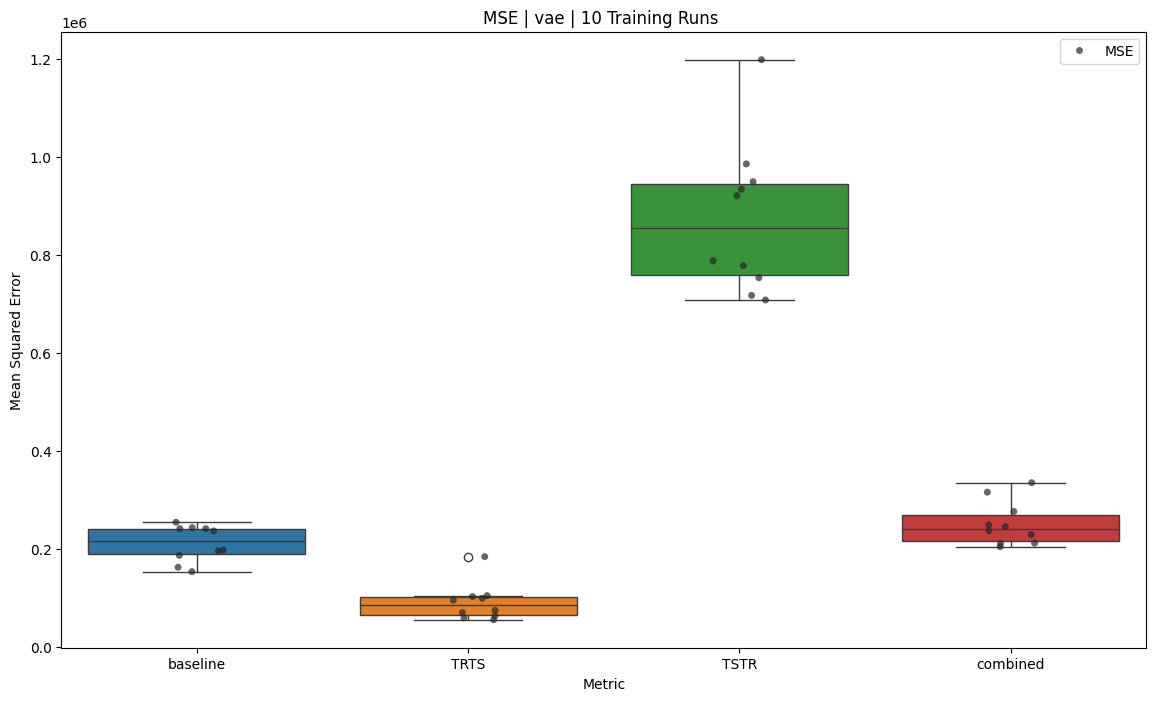

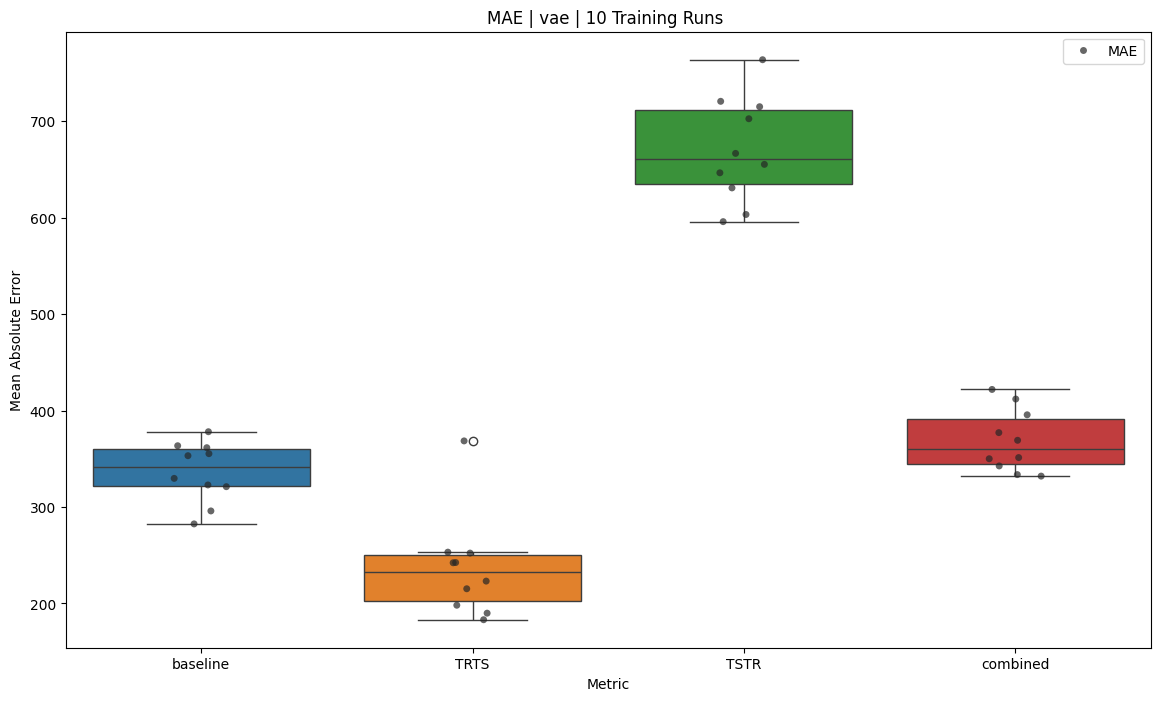

In [10]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [11]:
0.2*1e06

200000.0